<a href="https://colab.research.google.com/github/priya21662/sa2025/blob/main/Parking_Lots_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install pathway bokeh --quiet

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

In [86]:
df=pd.read_csv('dataset.csv')

In [87]:
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


In [89]:
df.shape

(18368, 12)

In [90]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

In [91]:
# Map TrafficCondition to numeric
traffic_map = {'low': 1, 'medium': 2, 'high': 3, 'average': 2} # Added 'average'
df['TrafficLevel'] = df['TrafficConditionNearby'].map(traffic_map)
# Fill any NaN values in TrafficLevel with 0
df['TrafficLevel'] = df['TrafficLevel'].fillna(0)

In [92]:
df.columns

Index(['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude',
       'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength',
       'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime', 'Timestamp',
       'TrafficLevel'],
      dtype='object')

In [93]:
df.dtypes

,0
ID,int64
SystemCodeNumber,object
Capacity,int64
Latitude,float64
Longitude,float64
Occupancy,int64
VehicleType,object
TrafficConditionNearby,object
QueueLength,int64
IsSpecialDay,int64


In [94]:
df.replace(".", pd.NA, inplace=True)

# Convert columns to numeric and fill NaNs (without chaining)
df["Occupancy"] = pd.to_numeric(df["Occupancy"], errors='coerce')
df["Occupancy"] = df["Occupancy"].fillna(0)

df["Capacity"] = pd.to_numeric(df["Capacity"], errors='coerce')
df["Capacity"] = df["Capacity"].fillna(0)




In [95]:
# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

In [96]:
# Save the selected columns to a CSV file for streaming or downstream processing
df[["Timestamp", "Occupancy", "Capacity","IsSpecialDay","QueueLength","TrafficLevel"
]].to_csv("parking_stream_cleaned.csv", index=False)

Demand Based Price Function

In [97]:
# Define the schema for the streaming data using Pathway
# This schema specifies the expected structure of each data row in the stream

class ParkingSchema(pw.Schema):
    Timestamp: str  # Let Pathway infer the datetime type
    Occupancy: float   # Number of occupied parking spots
    Capacity: float    # Total parking capacity at the location
    IsSpecialDay: float  # Represents if the day is a special day (e.g., holiday)
    QueueLength: float # Length of the queue for parking
    TrafficLevel: float # Numeric representation of nearby traffic condition

In [98]:
# Load the data as a simulated stream using Pathway's replay_csv function
# This replays the CSV data at a controlled input rate to mimic real-time streaming
# input_rate=1000 means approximately 1000 rows per second will be ingested into the stream.

data = pw.demo.replay_csv("parking_stream_cleaned.csv", schema=ParkingSchema, input_rate=100)

In [99]:
# Define the datetime format to parse the 'Timestamp' column
fmt = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00"),
    #IsSpecialDay = data.IsSpecialDay.astype(float) # Explicitly cast to float
)

In [100]:
import datetime
import numpy as np # Import numpy for isnan

# Constants
base_price = 10
lambda_weight = 2.5

# STEP 1: Tumbling daily window with feature aggregation
delta_window = (
    data_with_time.windowby(
        pw.this.t,  # Timestamp column (already parsed earlier)
        instance=pw.this.day,  # Grouping per calendar day
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t=pw.this._pw_window_end,  # End of the daily window
        occ_max=pw.reducers.max(pw.this.Occupancy),
        occ_min=pw.reducers.min(pw.this.Occupancy),
        cap=pw.reducers.max(pw.this.Capacity),
        q_len_avg=pw.reducers.avg(pw.this.QueueLength),
        traffic_avg=pw.reducers.avg(pw.this.TrafficLevel),
        special_day_max=pw.reducers.max(pw.this.IsSpecialDay),

    )
)

# Select the columns needed for subsequent calculations
delta_window_selected = delta_window.select(
    pw.this.t,
    pw.this.occ_max,
    pw.this.occ_min,
    pw.this.cap,
    pw.this.q_len_avg,
    pw.this.special_day_max,
    pw.this.traffic_avg
)


# STEP 2: Compute demand fluctuation
delta_window_calculated = delta_window_selected.with_columns(
    demand_fluctuation=(pw.this.occ_max - pw.this.occ_min) / pw.this.cap
)

# STEP 3: Compute demand score
delta_window_calculated = delta_window_calculated.with_columns(
    demand_score=(
        0.4 * pw.this.demand_fluctuation +
        0.2 * (pw.this.q_len_avg / 10) +
        0.2 * (pw.this.traffic_avg / 3) +
        0.1 * pw.this.special_day_max

    )

)

# STEP 4: Compute final dynamic price
delta_window = delta_window_calculated.with_columns(
    price=base_price + lambda_weight * pw.this.demand_score
)

In [101]:
import bokeh.plotting
import bokeh.io
import panel as pn

# Activate Panel and Bokeh inline output
pn.extension('tabulator', sizing_mode="stretch_width")
bokeh.io.output_notebook()

# Define Bokeh plotter for daily pricing
def price_plotter(source):
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Pathway: Daily Parking Price",
        x_axis_type="datetime",
        x_axis_label="Date",
        y_axis_label="Price ($)",
        tools="pan,wheel_zoom,box_zoom,reset,save",
    )
    fig.line("t", "price", source=source, line_width=2, color="navy", legend_label="Price")
    fig.scatter("t", "price", source=source, size=6, color="red", marker="circle")
    fig.legend.location = "top_left"
    fig.legend.click_policy = "hide"
    return fig

# Bind the Pathway stream to Bokeh plot
viz = delta_window.plot(price_plotter, sorting_col="t")


pn.Column(viz).servable()


Column(sizing_mode='stretch_width')
    [0] Column(sizing_mode='stretch_width')
        [0] Row(sizing_mode='stretch_width')
            [0] Markdown(str, sizing_mode='stretch_width')
            [1] TooltipIcon(sizing_mode='stretch_width', value='Table depends o...)
        [1] Bokeh(figure, sizing_mode='stretch_width')

In [102]:
%%capture --no-display
pw.run()

Output()

Linear Pricing Model

In [103]:
# Define the datetime format to parse the 'Timestamp' column
fmt = "%Y-%m-%d %H:%M:%S"

# Ensure the 'Timestamp' column is datetime type in the DataFrame
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

# Set alpha (sensitivity) and starting base price
alpha = 0.5
base_price = 10.0

# Calculate demand ratio and baseline price directly in pandas
df['demand_ratio'] = df['Occupancy'] / df['Capacity']
df['baseline_price'] = base_price + alpha * df['demand_ratio']

# Select the relevant columns for plotting
baseline_price_df = df[['Timestamp', 'baseline_price']].copy()

# Sort by Timestamp to ensure correct plotting
baseline_price_df = baseline_price_df.sort_values('Timestamp').reset_index(drop=True)



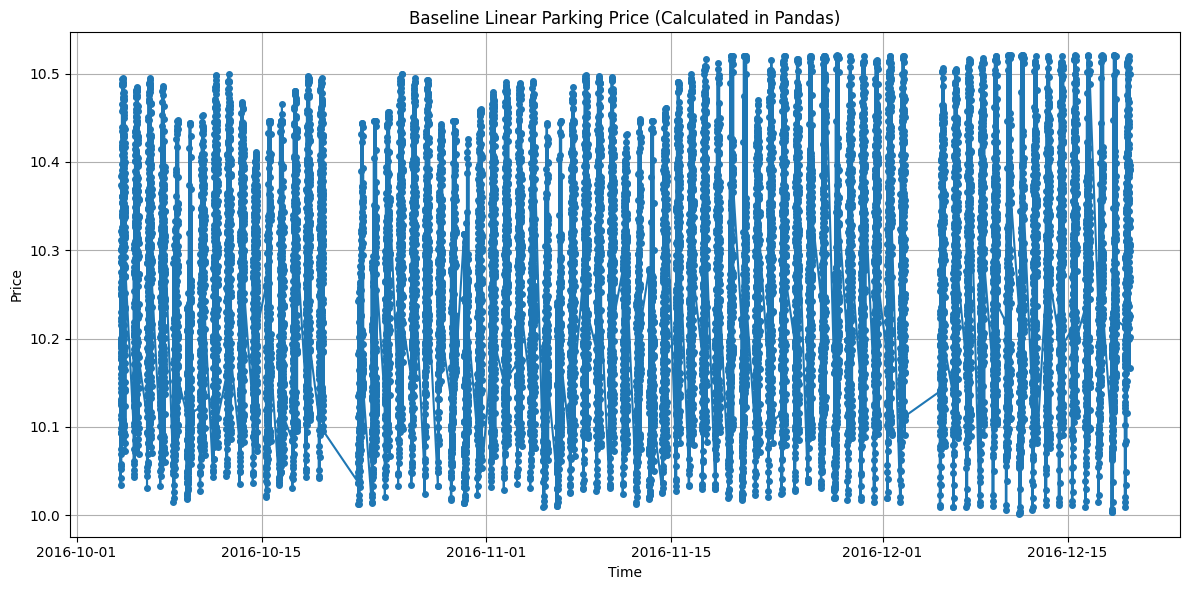

In [104]:
# Now, use Matplotlib to plot this pandas DataFrame
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(baseline_price_df['Timestamp'], baseline_price_df['baseline_price'], marker='o', linestyle='-', markersize=4)
plt.title("Baseline Linear Parking Price (Calculated in Pandas)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [117]:
import bokeh.plotting
import bokeh.io
import panel as pn
from bokeh.models import ColumnDataSource

# Activate Panel and Bokeh inline output
pn.extension(comms='colab', sizing_mode="stretch_width")
bokeh.io.output_notebook()

# Assuming baseline_price_df is already created and contains the data
# Convert the pandas DataFrame to a ColumnDataSource for plotting
source_linear = ColumnDataSource(baseline_price_df)

# Define Bokeh plotter function for linear pricing
def linear_price_plotter(source):
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Bokeh: Linear Parking Price Over Time",
        x_axis_type="datetime",
        x_axis_label="Time",
        y_axis_label="Price ($)",
        tools="pan,wheel_zoom,box_zoom,reset,save",
    )
    fig.line("Timestamp", "baseline_price", source=source, line_width=2, color="blue", legend_label="Linear Price")
    fig.circle("Timestamp", "baseline_price", source=source, size=6, color="darkblue", legend_label="Data Points")

    fig.legend.location = "top_left"
    fig.legend.click_policy = "hide"
    return fig

# Create the plot
viz_linear = linear_price_plotter(source_linear)

# Display the plot
pn.Column(viz_linear).servable()
pn.Column(viz_linear)

Column(sizing_mode='stretch_width')
    [0] Bokeh(figure, sizing_mode='stretch_width')

Competitive Model

In [105]:
import pathway as pw

competitors = pw.debug.table_from_markdown('''
CompID | Latitude | Longitude | Price
1      | 12.9716  | 77.5946   | 11.0
2      | 12.9350  | 77.6100   | 12.5
3      | 12.9600  | 77.5800   | 10.8
''')




In [106]:
YOUR_LAT = 12.9611
YOUR_LON = 77.6387


In [107]:
from math import radians, sin, cos, sqrt, atan2

@pw.udf
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))


In [108]:
@pw.udf
def calculate_inverse(distance: float) -> float:
    """Calculates the inverse of a number, handling division by zero."""
    if distance == 0:
        return 0.0  # Or some other appropriate value
    return 1.0 / distance

In [109]:
competitors = competitors.with_columns(
    distance = haversine(YOUR_LAT, YOUR_LON, pw.this.Latitude, pw.this.Longitude)
)

competitors = competitors.with_columns(
    weight = calculate_inverse(pw.this.distance)
)

In [110]:
competitor_agg = competitors.reduce(
    total_weight = pw.reducers.sum(pw.this.weight),
    weighted_price = pw.reducers.sum(pw.this.Price * pw.this.weight)
).with_columns(
    comp_price = pw.this.weighted_price / pw.this.total_weight
)


In [111]:
base_price = 10
lambda_weight = 2.5
gamma = 0.3

# Create dummy key using numeric columns only
dw = delta_window.select(
    t=pw.this.t,
    demand_score=pw.this.demand_score
).with_columns(
    key=(pw.this.demand_score * 0 + 1)
)

comp = competitor_agg.select(
    comp_price=pw.this.comp_price
).with_columns(
    key=(pw.this.comp_price * 0 + 1)
)




In [112]:
joined = dw.join(comp).select(
    key=pw.left.key,  # keep the join key if needed
    t=pw.left.t,
    demand_score=pw.left.demand_score,
    comp_price=pw.right.comp_price,
    price=(base_price + lambda_weight * pw.left.demand_score) * (1 - gamma) +
          gamma * pw.right.comp_price
)

from bokeh.models import ColumnDataSource

# Initialize panel extension
pn.extension(comms='colab')  # Use 'colab' if you're in Google Colab, else just pn.extension()


In [113]:
def price_plotter(source):
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Final Competitive Parking Price Over Time",
        x_axis_type="datetime",
        x_axis_label="Date",
        y_axis_label="Price ($)",
        tools="pan,wheel_zoom,box_zoom,reset,save",
    )
    fig.line("t", "price", source=source, line_width=2, color="navy", legend_label="Final Price")
    fig.circle("t", "price", source=source, size=6, color="orange", legend_label="Data Points")

    fig.legend.location = "top_left"
    fig.legend.click_policy = "hide"
    return fig


In [114]:
# Use the competitive price plotter function defined earlier
from bokeh.models import ColumnDataSource
import panel as pn
import bokeh.plotting
import pandas as pd

# Read the results from the temporary CSV file into a pandas DataFrame
joined_static_df = pd.read_csv("joined_results.csv")

# Convert 't' column to datetime
joined_static_df['t'] = pd.to_datetime(joined_static_df['t'])


# Convert the pandas DataFrame to a ColumnDataSource for plotting
source = ColumnDataSource(joined_static_df)
viz_competitive = price_plotter(source)

pn.extension(comms='colab')
pn.Column(viz_competitive).servable()
pn.Column(viz_competitive)

Column(sizing_mode='stretch_width')
    [0] Bokeh(figure, sizing_mode='stretch_width')

In [116]:
%%capture --no-display
pw.run()

# Write the results of the joined table to a temporary CSV file after the stream finishes
pw.io.csv.write(joined, "joined_results.csv")

# Write the results of the delta_window table to a temporary CSV file after the stream finishes
#pw.io.csv.write(delta_window, "demand_results.csv")

Output()